# Prac Deep Learning Sys (COMS 6998-015)
## Homework 3
### Nathan Coulibaly, nmc2169

## Problem 1

1. Evaluation of pretrained MobilenetV1 SSD (mobilenet-v1-ssd-mp-0_675.pth) with Pascal VOC 2007 Dataset:

    **Average Precision Per Class:**

    - **aeroplane**: 0.6843
    - **bicycle**: 0.7911
    - **bird**: 0.6172
    - **boat**: 0.5613
    - **bottle**: 0.3483
    - **bus**: 0.7684
    - **car**: 0.7281
    - **cat**: 0.8369
    - **chair**: 0.5169
    - **cow**: 0.6239
    - **diningtable**: 0.7063
    - **dog**: 0.7873
    - **horse**: 0.8195
    - **motorbike**: 0.7924
    - **person**: 0.7023
    - **pottedplant**: 0.3985
    - **sheep**: 0.6067
    - **sofa**: 0.7572
    - **train**: 0.8262
    - **tvmonitor**: 0.6465

    **Average Precision Across All Classes**: **0.6760**
    

Pretrained mobilenet-v1-ssd-mp-0_675 model with 3 classes (BACKGROUND, Airplane, Helicopter)

**Average Precision Per-class:**
- **Airplane**: 0.007641559442716817
- **Helicopter**: 0.005506622493994895

**Average Precision Across All Classes:** 0.006574090968355857

After fine-tuning for 10 epochs on open_images airplane and helicopter dataset, Validation Loss: 1.9261, Validation Regression Loss 0.6156, Validation Classification Loss: 1.3105

**Average Precision Per-class:**
 - **Airplane:** 0.7871694636324705
 - **Helicopter:** 0.8729167315760018

**Average Precision Across All Classes:** 0.8300430976042361

In [1]:
import torch
import torch.onnx
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd  # Adjust the import if necessary

model_path = "models/mb1-ssd-Epoch-9-Loss-1.9260564812010141.pth"
model = create_mobilenetv1_ssd(num_classes=3) 
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Define a dummy input tensor
dummy_input = torch.randn(1, 3, 300, 300)

with torch.no_grad():
    pytorch_output = model(dummy_input)

print(f"PyTorch output: {pytorch_output}")

# Export the model to ONNX format
onnx_path = "models/finetuned-mb1-ssd.onnx" 
torch.onnx.export(
    model,                     # Model to be exported
    dummy_input,               # Dummy input tensor
    onnx_path,                 # Output file path
    export_params=True,        # Store the trained parameter weights inside the model file
    opset_version=11,          # ONNX opset version to export the model
    do_constant_folding=True,  # Whether to execute constant folding for optimization
    input_names=['input'],     # Input name (optional)
    output_names=['output']    # Output name (optional)
)

print(f"Model exported to {onnx_path}")

/tmp/ipykernel_31747/425630200.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


PyTorch output: (tensor([[[ 2.7067, -0.0481, -2.5708],
         [ 3.0105, -0.3939, -2.5286],
         [ 2.6784, -0.0125, -2.6966],
         ...,
         [ 2.1973, -0.0763, -2.1296],
         [ 2.4602,  0.1056, -2.5215],
         [ 2.1238, -0.1471, -2.0171]]]), tensor([[[ 1.2836,  1.5608, -4.3793, -5.8038],
         [ 0.1748,  0.3736, -0.5482, -1.3703],
         [ 1.3982,  0.6396, -5.4957, -4.8404],
         ...,
         [ 0.0265,  0.1725,  1.6046, -0.3113],
         [ 0.1325,  0.2001, -0.3001,  2.1285],
         [-0.0083,  0.1599,  2.5981, -0.2166]]]))
Model exported to models/finetuned-mb1-ssd.onnx


In [2]:
import onnx

# Load the ONNX model
onnx_model_path = "models/finetuned-mb1-ssd.onnx"
model = onnx.load(onnx_model_path)

# Verify the model’s structure
try:
    onnx.checker.check_model(model)
    print("The ONNX model is valid.")
except onnx.checker.ValidationError as e:
    print(f"The ONNX model is invalid: {e}")

The ONNX model is valid.


In [3]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model_path = "models/finetuned-mb1-ssd.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

# Define a dummy input tensor
dummy_input = np.random.randn(1, 3, 300, 300).astype(np.float32)

# Run the ONNX model with the dummy input tensor
input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name

# Run the ONNX inference
outputs = ort_session.run([output_name], {input_name: dummy_input})

print("Model Output:", outputs[0])

Model Output: [[[ 2.628398   -0.09165876 -2.416489  ]
  [ 3.0297675  -0.4312416  -2.5319319 ]
  [ 2.660162    0.05083796 -2.7098558 ]
  ...
  [ 2.2011666  -0.07641503 -2.132676  ]
  [ 2.469308    0.10345399 -2.5300725 ]
  [ 2.128943   -0.14993942 -2.0211074 ]]]


In [4]:
pytorch_output_np = pytorch_output[0].detach().cpu().numpy()  # Adjust indexing if model returns multiple outputs
onnx_output = outputs[0]

if np.allclose(pytorch_output_np, onnx_output, rtol=1e-5, atol=1e-5):
    print("The outputs from PyTorch and ONNX Runtime match within the specified tolerance.")
else:
    print("The outputs from PyTorch and ONNX Runtime do not match.")

The outputs from PyTorch and ONNX Runtime do not match.


- rtol=1e-5: Relative tolerance of 1e-5 means that the difference between PyTorch and ONNX values can be up to 0.001% of the PyTorch value and still be considered a match.
- atol=1e-5: Absolute tolerance of 1e-5 means that very small values (close to zero) can differ by up to 1e-5.


In [5]:
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms as transforms

In [6]:
# Define paths to the images and model
image_paths = ["data/test_images/airplane.jpg", "data/test_images/helicopter.jpg"]  
onnx_model_path = "models/finetuned-mb1-ssd.onnx"

# Create an inference session with ONNX Runtime
session = ort.InferenceSession(onnx_model_path)

# Preprocessing function
def preprocess_image(image_path, input_size=(300, 300)):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    
    # Define preprocessing steps (resize, normalize, etc.)
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust mean/std based on model needs
    ])
    
    # Apply transformations
    image_tensor = preprocess(image)
    
    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)  # Shape: (1, 3, 300, 300)
    
    return image_tensor.numpy()  # Convert to numpy for ONNX Runtime

In [7]:
for image_path in image_paths:
    # Preprocess the image
    input_data = preprocess_image(image_path)
    
    # Get input and output names for ONNX Runtime
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    
    # Run inference
    outputs = session.run([output_name], {input_name: input_data})
    
    # Print the output (for real applications, interpret this output properly)
    print(f"Output for {image_path}: {outputs[0]}")

Output for data/test_images/airplane.jpg: [[[ 4.138382   -0.9878388  -3.0577788 ]
  [ 4.22545    -1.4909672  -2.6169086 ]
  [ 3.8684378  -1.0116055  -2.864805  ]
  ...
  [ 0.5566062   1.7188514  -2.3376985 ]
  [-1.7088915   3.212818   -1.5116981 ]
  [ 2.3896177   0.58438176 -2.919279  ]]]
Output for data/test_images/helicopter.jpg: [[[ 4.265738   -0.82885605 -3.3536644 ]
  [ 4.3293333  -0.9208403  -3.3959553 ]
  [ 4.0182996  -0.63204706 -3.3168209 ]
  ...
  [ 0.50133926 -2.3493757   1.7498918 ]
  [-0.7328597  -1.7276728   2.302973  ]
  [ 1.6628044  -2.7264628   1.0709631 ]]]


In [33]:
labels = ["airplane", "helicopter", "BACKGROUND"]

In [34]:
def preprocess_image(image_path, input_size=(300, 300)):
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust mean/std as needed
    ])
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor.numpy(), image

In [35]:
def parse_output(outputs, threshold=0.5):
    # Extract the single tensor from outputs
    detections = outputs[0]
    
    # Initialize lists for results
    result_boxes = []  # If there are no bounding boxes, this remains empty
    result_labels = []
    result_scores = []
    
    # Iterate over the detections
    for detection in detections[0]:  # Iterate over 3000 detections
        class_confidence, class_id, _ = detection  # Hypothetical structure
        if class_confidence > threshold:
            result_labels.append(labels[int(class_id)])  # Assuming class_id corresponds to a label index
            result_scores.append(class_confidence)
            # Add a dummy box if your SSD model is supposed to provide bounding boxes
            result_boxes.append([0, 0, 1, 1])  # Dummy bounding box (replace with actual if available)

    return result_boxes, result_labels, result_scores

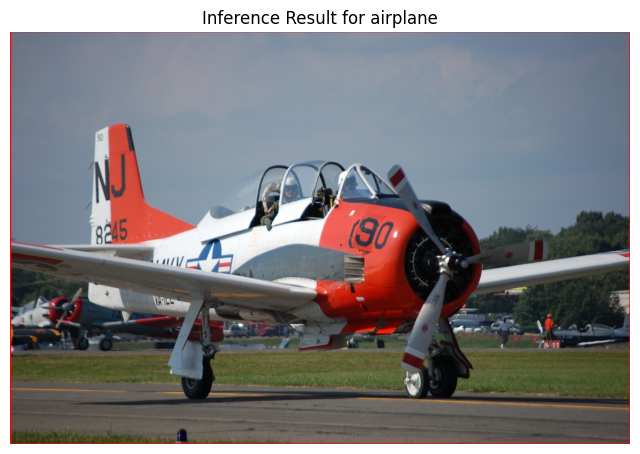

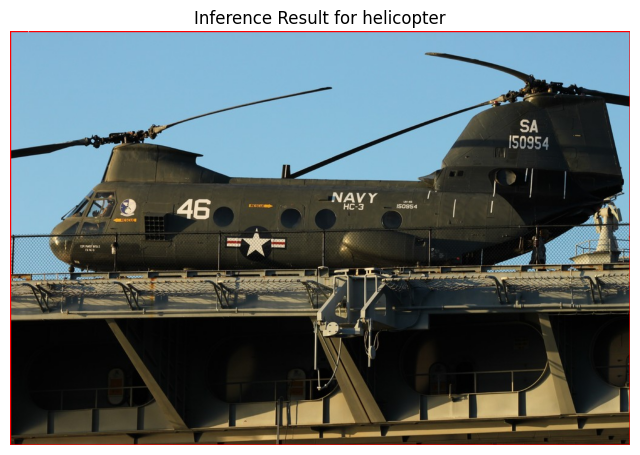

In [36]:
import matplotlib.pyplot as plt

for image_path in image_paths:
    # Preprocess the image
    input_data, original_image = preprocess_image(image_path)

    # Run inference
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    outputs = session.run([output_name], {input_name: input_data})

    # Parse the output
    result_boxes, result_labels, result_scores = parse_output(outputs)

    # Annotate the image
    draw = ImageDraw.Draw(original_image)
    font = ImageFont.load_default()
    for box, label, score in zip(result_boxes, result_labels, result_scores):
        xmin, ymin, xmax, ymax = box
        xmin, ymin, xmax, ymax = int(xmin * original_image.width), int(ymin * original_image.height), int(xmax * original_image.width), int(ymax * original_image.height)
        
        # Draw bounding box
        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="red", width=2)
        
        # Draw label and score
        text = f"{label}: {score:.2f}"
        text_size = font.getbbox(text)  # Get the bounding box of the text
        text_width = text_size[2] - text_size[0]
        text_height = text_size[3] - text_size[1]

        # Draw the background rectangle for the label
        draw.rectangle([(xmin, ymin - text_height), (xmin + text_width, ymin)], fill="red")
        draw.text((xmin, ymin - text_height), text, fill="white", font=font)

    # Display the annotated image
    plt.figure(figsize=(8, 8))
    plt.imshow(original_image)
    plt.axis("off")
    plt.title(f"Inference Result for {label}")
    plt.show()

## Problem 2

1. Fine-tuning with Daimler Ped dataset from the Visual Domain Decathlon

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [46]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [47]:
data_dir = 'data/daimlerpedcls'
image_datasets = {
    'train': ImageFolder(data_dir + '/train', data_transforms['train']),
    'val': ImageFolder(data_dir + '/val', data_transforms['val']),
}
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=64, shuffle=False, num_workers=4),
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [48]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)  # 2 classes for the Daimler Ped dataset
model_ft = model_ft.to(device)

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

scheduler = MultiStepLR(optimizer_ft, milestones=[40, 80, 120], gamma=0.1)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer_ft.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer_ft.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print('Training complete')

Epoch 0/99
----------


In [ ]:
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=150):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Training complete')
    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, best_acc

## Problem 3

1. Dataset Setup

In [1]:
from datasets import load_dataset
import random

# Load the GSM8K dataset from Hugging Face
gsm8k = load_dataset("gsm8k", "main", split="test")

# Randomly select one question from the test set
random_question = gsm8k[random.randint(0, len(gsm8k) - 1)]

# Display the selected question
print("Selected Question:")
print("Question:", random_question['question'])
print("Answer:", random_question['answer'])

/Users/nathancoulibaly/Documents/Columbia_Grad/LLM & DL System Performance/HW3/pytorch-ssd/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Selected Question:
Question: Alex, Stan, and Adelwolfe are trying to catch them all, Pokemon that is.  Together they have caught 339 Pokemon.  Alex has caught 5 more than Stan, and Stan has caught 13 less than 4 times as many as Adelwolfe has caught. How many Pokemon has Stan caught?
Answer: Let x represent the number of Pokemon Adelwolfe caught
Stan: 4x-13
Alex: 5+(4x-13)=4x-8
Total: x+4x-13+4x-8=339
9x-21=339
9x=360
x=<<40=40>>40 Pokemon
Stan:4(40)-13=147 Pokemon
#### 147


2. Model Selection: I will be using the Gemini API with gemini-1.5-pro

In [20]:
import google.generativeai as genai
import os
from dotenv import load_dotenv

load_dotenv()

# Configure the Gemini API with your API key
genai.configure(api_key=os.environ["GEMINI_API_KEY"])

In [8]:
prompt = f"Question: {random_question['question']}\n\nPlease solve this problem step by step."

In [10]:
# Initialize the model
model = genai.GenerativeModel(model_name="gemini-1.5-pro")

# Generate a response
response = model.generate_content(prompt)

# Display the model's response
print("Model's Response:")
print(response.text)

Model's Response:
1. **Define variables:**
   * Let 'a' represent the number of Pokemon Alex caught.
   * Let 's' represent the number of Pokemon Stan caught.
   * Let 'w' represent the number of Pokemon Adelwolfe caught.

2. **Set up equations based on the given information:**
   * a + s + w = 339  (They caught 339 Pokemon in total)
   * a = s + 5        (Alex caught 5 more than Stan)
   * s = 4w - 13      (Stan caught 13 less than 4 times Adelwolfe's catch)

3. **Solve for 'w' (Adelwolfe's Pokemon):**
   * Substitute the first two equations into the third to eliminate 'a':
     (s + 5) + s + w = 339
     2s + w + 5 = 339
     2s + w = 334
   * Now we have two equations with 's' and 'w':
     s = 4w - 13
     2s + w = 334
   * Substitute the first equation into the second:
     2(4w - 13) + w = 334
     8w - 26 + w = 334
     9w - 26 = 334
     9w = 360
     w = 40

4. **Solve for 's' (Stan's Pokemon):**
   * Substitute the value of 'w' back into the equation s = 4w - 13:
     s = 4 *

3. Prompt Engineering

In [15]:
# General function to generate a solution based on a prompt and a problem
def generate_solution(prompt, problem):
    full_prompt = f"{prompt}\n\nQuestion: {problem}\nLet's think step by step."
    response = model.generate_content(full_prompt)
    return response.text.strip()

# One-shot prompting for numeric answers
def one_shot_prompting_numeric(problem_to_solve):
    example_question = (
        "A store sells notebooks in packs of 12 and markers in packs of 8. "
        "If someone buys 5 packs of notebooks and 3 packs of markers, "
        "how many individual items do they have in total?"
    )
    example_solution = (
        "First, calculate the total number of notebooks: 5 packs * 12 = 60.\n"
        "Next, calculate the total number of markers: 3 packs * 8 = 24.\n"
        "Now, add these together: 60 + 24 = 84.\n"
        "The answer is 84."
    )
    one_shot_prompt = (
        f"Question: {example_question}\nSolution: {example_solution}\n\n"
        f"Now solve this:\n{problem_to_solve}\nSolution:"
    )
    return generate_solution(one_shot_prompt, problem_to_solve)

# Two-shot prompting for numeric answers
def two_shot_prompting_numeric(problem_to_solve):
    example_1_question = (
        "A factory produces 120 gadgets per hour. If it operates 8 hours per day, "
        "how many gadgets does it produce in 5 days?"
    )
    example_1_solution = (
        "First, calculate the daily production: 120 gadgets * 8 hours = 960 gadgets per day.\n"
        "Then, calculate the production over 5 days: 960 * 5 = 4800.\n"
        "The answer is 4800."
    )
    example_2_question = (
        "Sarah has a collection of 90 stamps. She gives 1/3 of them to her friend, "
        "and then buys 30 more. How many stamps does she have now?"
    )
    example_2_solution = (
        "First, calculate how many stamps she gives away: 90 * 1/3 = 30.\n"
        "Subtract this from her original collection: 90 - 30 = 60.\n"
        "Now add the stamps she bought: 60 + 30 = 90.\n"
        "The answer is 90."
    )
    two_shot_prompt = (
        f"Question: {example_1_question}\nSolution: {example_1_solution}\n\n"
        f"Question: {example_2_question}\nSolution: {example_2_solution}\n\n"
        f"Now solve this:\n{problem_to_solve}\nSolution:"
    )
    return generate_solution(two_shot_prompt, problem_to_solve)

# Two-shot Chain-of-Thought (CoT) prompting 
def two_shot_cot_prompting(problem_to_solve):
    example_1_question = (
        "A school buys 4 sets of books, each containing 15 books. Then, the school receives a donation "
        "of 20 more books. If each classroom receives an equal share of 5 classrooms, "
        "how many books does each classroom get?"
    )
    example_1_cot_solution = (
        "First, calculate the total books purchased: 4 sets * 15 = 60 books.\n"
        "Next, add the donated books: 60 + 20 = 80.\n"
        "Now, divide this among the classrooms: 80 / 5 = 16.\n"
        "Each classroom gets 16 books."
    )
    example_2_question = (
        "A gardener plants 3 rows of 25 flowers each in the morning, and 2 rows of 30 flowers each in the afternoon. "
        "In the evening, 10 flowers are eaten by deer. How many flowers are left in the garden?"
    )
    example_2_cot_solution = (
        "First, calculate the flowers planted in the morning: 3 * 25 = 75.\n"
        "Then, calculate the flowers planted in the afternoon: 2 * 30 = 60.\n"
        "Add them to get the total flowers: 75 + 60 = 135.\n"
        "Now, subtract the flowers eaten by deer: 135 - 10 = 125.\n"
        "The answer is 125."
    )
    cot_prompt = (
        f"Question: {example_1_question}\nSolution: {example_1_cot_solution}\n\n"
        f"Question: {example_2_question}\nSolution: {example_2_cot_solution}\n\n"
        f"Now solve this step-by-step:\n{problem_to_solve}\nSolution:"
    )
    return generate_solution(cot_prompt, problem_to_solve)

In [14]:
random_question = gsm8k[random.randint(0, len(gsm8k) - 1)]
# Display the selected question
print("Selected Question:")
print("Question:", random_question['question'])
print("Answer:", random_question['answer'])

print("One-shot Prompting:")
print(one_shot_prompting_numeric(random_question['question']))

print("Two-shot Prompting:")
print(two_shot_prompting_numeric(random_question['question']))

print("Two-shot Chain-of-Thought (CoT) Prompting:")
print(two_shot_cot_prompting(random_question['question']))

Selected Question:
Question: Dylan attended a wedding where there were 100 guests in the reception. Each guest brought a plate of 15 cookies. The bride decided to give 1/2 of the cookies to the church next door as a thank you for helping in the wedding reception. If each person in the church next door got 15 cookies, how many people were in the church next door?
Answer: If each of the 100 guests brought a plate of 15 cookies, then the total number of cookies brought is 100*15 = <<100*15=1500>>1500 cookies.
If the next church was given 1/2 the number of cookies, then they got 1/2*1500 = <<1/2*1500=750>>750 cookies.
If each person in the church next door got 15 cookies, then there were 750/15 = <<750/15=50>>50 people.
#### 50
One-shot Prompting:
1. **Calculate the total number of cookies:** 100 guests * 15 cookies/guest = 1500 cookies

2. **Calculate the number of cookies given to the church:** 1500 cookies * (1/2) = 750 cookies

3. **Calculate the number of people in the church:** 750 c

4. Prompt Refinement

In [16]:
# Updated function to generate a solution
def generate_solution_refined(prompt, problem):
    refined_prompt = f"{prompt}\n\nQuestion: {problem}\nLet's work this out carefully and verify each step."
    response = model.generate_content(refined_prompt)
    return response.text.strip()

# Refined one-shot prompting 
def refined_one_shot_prompting_numeric(problem_to_solve):
    example_question = (
        "A warehouse has 150 boxes. A truck carries away 3 loads of 30 boxes each, "
        "then 20 more boxes are added. How many boxes remain?"
    )
    example_solution = (
        "First, calculate how many boxes the truck carries away: 3 * 30 = 90.\n"
        "Subtract this from the initial count: 150 - 90 = 60.\n"
        "Now, add the extra boxes: 60 + 20 = 80.\n"
        "The answer is 80."
    )
    refined_prompt = (
        f"Question: {example_question}\nSolution: {example_solution}\n\n"
        f"Now solve this carefully and check your answer:\n{problem_to_solve}\nSolution:"
    )
    return generate_solution_refined(refined_prompt, problem_to_solve)

# Refined two-shot prompting 
def refined_two_shot_prompting_numeric(problem_to_solve):
    example_1_question = (
        "A train has 120 seats. If it fills 4 carriages with 20 seats each, how many seats remain empty?"
    )
    example_1_solution = (
        "First, calculate the filled seats: 4 * 20 = 80.\n"
        "Subtract this from the total seats: 120 - 80 = 40.\n"
        "The answer is 40."
    )
    example_2_question = (
        "If a bookstore has 200 books and sells 35% of them, how many books are left?"
    )
    example_2_solution = (
        "Calculate 35% of 200: 200 * 0.35 = 70.\n"
        "Subtract this from the total: 200 - 70 = 130.\n"
        "The answer is 130."
    )
    refined_prompt = (
        f"Question: {example_1_question}\nSolution: {example_1_solution}\n\n"
        f"Question: {example_2_question}\nSolution: {example_2_solution}\n\n"
        f"Now solve this carefully, performing each operation:\n{problem_to_solve}\nSolution:"
    )
    return generate_solution_refined(refined_prompt, problem_to_solve)

# Refined two-shot Chain-of-Thought (CoT) prompting
def refined_two_shot_cot_prompting(problem_to_solve):
    example_1_question = (
        "A farmer has 3 fields. Each field has 20 apple trees. If he plants 5 more trees in each field, "
        "how many trees are there in total?"
    )
    example_1_cot_solution = (
        "First, calculate the initial trees: 3 fields * 20 = 60.\n"
        "Now add the extra trees per field: 3 * 5 = 15.\n"
        "Total trees: 60 + 15 = 75.\n"
        "The answer is 75."
    )
    example_2_question = (
        "A hiker walks 3 miles every day for 5 days, then 4 miles each day for the next 3 days. "
        "How many miles has he walked in total?"
    )
    example_2_cot_solution = (
        "Calculate the distance for the first 5 days: 3 miles * 5 = 15.\n"
        "Next, for the following 3 days: 4 miles * 3 = 12.\n"
        "Add them together: 15 + 12 = 27.\n"
        "The answer is 27."
    )
    refined_cot_prompt = (
        f"Question: {example_1_question}\nSolution: {example_1_cot_solution}\n\n"
        f"Question: {example_2_question}\nSolution: {example_2_cot_solution}\n\n"
        f"Now solve this step-by-step, verifying each calculation:\n{problem_to_solve}\nSolution:"
    )
    return generate_solution_refined(refined_cot_prompt, problem_to_solve)

5. Evaluation
- Testing with original prompts above

In [17]:
random_question = gsm8k[random.randint(0, len(gsm8k) - 1)]
print("Selected Question:")
print("Question:", random_question['question'])
print("Answer:", random_question['answer'])

print("Refined One-shot Prompting:")
print(refined_one_shot_prompting_numeric(random_question['question']))

print("Refined Two-shot Prompting:")
print(refined_two_shot_prompting_numeric(random_question['question']))

print("Refined Two-shot Chain-of-Thought (CoT) Prompting:")
print(refined_two_shot_cot_prompting(random_question['question']))

Selected Question:
Question: Tom went on a two-week-long trip through Europe. In the first 4 days, he traveled 200 kilometers every day, and over the next two days, he totaled only 30% of the distance traveled over the first four days. On the next day, he wasn't traveling at all. During the second week, he made 300 kilometers every day. How many kilometers in total did Tom make during his two-week-long trip?
Answer: In the first four days, Tom made 4 * 200 = <<4*200=800>>800 kilometers.
For the next two days, he made only 30/100 * 800 = <<30/100*800=240>>240 kilometers.
During the second week, Tom made 300 kilometers every day, which means 7 * 300 = <<7*300=2100>>2100 kilometers during the whole week.
During his whole trip, Tom made 800 + 240 + 2100 = <<800+240+2100=3140>>3140 kilometers.
#### 3140
Refined One-shot Prompting:
1. **First 4 days:** Tom traveled 200 km/day * 4 days = 800 km

2. **Next 2 days:** He traveled 30% of 800 km = 0.30 * 800 km = 240 km

3. **Next day:** 0 km (he 

My initial prompts were sufficient for answering all of the random questions I started with, however the answers with my refined prompts are very detailed in their solution walkthroughs.

1. One-Shot Prompting:

- Original Prompt: In the original one-shot prompt, the model accurately followed steps to calculate total cookies and distribute them, providing a clear and correct final answer. However, the steps were somewhat basic and didn’t encourage deeper validation, which is sufficient for straightforward calculations.
- Refined Prompt: The refined one-shot prompt introduced clearer, more structured steps and explicitly encouraged the model to check its calculations. This led to a more detailed breakdown, which was beneficial in multi-part problems, ensuring careful handling of each operation and adding precision.

2. Two-Shot Prompting:

- Original Prompt: The original two-shot prompt correctly solved simple calculations, adding a second example for guidance. It correctly computed each step, but similar to the one-shot approach, it did not prompt the model to verify its answer thoroughly.
- Refined Prompt: The refined two-shot prompt further improved accuracy by adding explicit instructions for multi-step operations (e.g., calculating percentages or working through specific periods in a week). This additional guidance helped in breaking down complex problems and was particularly useful in cases where multiple steps were required, leading to higher accuracy and a well-organized response.

3. Two-Shot Chain-of-Thought (CoT) Prompting:

- Original CoT Prompt: The original CoT prompt demonstrated improved logical reasoning over one-shot and two-shot prompts by breaking down the problem into intermediate steps. However, while it produced correct answers, it did not explicitly validate each calculation step-by-step, which could result in errors for more intricate problems.
- Refined CoT Prompt: In the refined CoT prompt, the model was encouraged not only to solve the problem step-by-step but also to verify each calculation along the way. This refinement was particularly effective in managing complex, multi-part problems (e.g., Tom’s travel distances over varying days). By prompting the model to confirm each intermediate answer, the refined CoT prompt ensured accuracy across multiple stages, making it ideal for detailed reasoning.

In summary, the refined prompting techniques, especially the two-shot CoT prompt, led to enhanced clarity, accuracy, and reliability in solving complex problems by adding verification steps and specific instructions. 

6. The majority of my work, school, and hobby-related experience with LLMs has been with OpenAI models such as GPT-3.5-turbo, GPT-4, and GPT-4o. I have some experience at work with LLama2 7B, but for the most part I have utilized the OpenAI API to access their models. I took this problem as an opportunity to explore Gemini (gemini-1.5-pro) and its API which was pleasantly easy to set up.

    I was worried that the prompt engineering skills I've built over the past few years with the GPT models wouldn't translate cleanly to Gemini, but I was still able to successfully craft prompts that delivered correct solutions which I was happy about. I am not sure whether it is just in my head or not, but I do think that the overall feel/tone of the responses, as well as the formatting is different from what I'm used to. Nevertheless, the more concise information and instructions I provided in the prompts, the better the responses. I thought that my refined, more complex responses may be difficult for the model to interpret and extrapolate in order to solve the unseen problems, but it performed well for my small sample of random questions

## Problem 4

1. Implementing search tool using SerpAPI

In [1]:
from langchain.agents import Tool
from serpapi import GoogleSearch
import os
from dotenv import load_dotenv

load_dotenv()

class SearchTool(Tool):
    def __init__(self, api_key=None):
        super().__init__(name="search", description="Performs a web search using SerpAPI.", func=self._run)

    def _run(self, query: str) -> str:
        """Run the search query using SerpAPI and return formatted results."""
        params = {
            "engine": "google",
            "q": query,
            "api_key": os.getenv("SERP_API_KEY"),
        }
        search = GoogleSearch(params)
        results = search.get_dict()
        
        # Format the results
        formatted_results = self.format_results(results)
        
        # Join results into a single string for easier display in the ReAct agent
        formatted_output = "\n".join(
            [f"Title: {item['title']}\nLink: {item['link']}\nSnippet: {item['snippet']}\n" for item in formatted_results]
        )
        
        return formatted_output

    def format_results(self, results):
        """Format search results to return only relevant information."""
        formatted_results = []
        
        if "organic_results" in results:
            for result in results["organic_results"]:
                title = result.get("title", "No title")
                link = result.get("link", "No link")
                snippet = result.get("snippet", "No snippet")
                
                # Each result is a dictionary with title, link, and snippet for easy access by the ReAct agent
                formatted_results.append({
                    "title": title,
                    "link": link,
                    "snippet": snippet
                })
        else:
            formatted_results.append({"error": "No results found"})

        return formatted_results

2. Create comparison tool

In [77]:
from langchain.tools import Tool
from langchain.prompts import PromptTemplate
from typing import List, Dict
import re

class ComparisonTool(Tool):
    def __init__(self):
        super().__init__(
            name="ComparisonTool",
            description="Compares items based on a specified category",
            func=self._run  # Pass _run as the function to execute
        )
        
    def _run(self, tool_input: str):
        # Parse items and category from the input string
        match = re.search(r'items: \[(.*?)\], category: "|\'(.*?)"|\'', tool_input)
        if match:
            items = [item.strip() for item in match.group(1).split(",")]
            category = match.group(2)
        else:
            return f"Error: Input format is incorrect. Expected format is 'items: [item1, item2, ...], category: \"category_name\"'. Received: {tool_input}"
        
        # Error handling for invalid inputs
        if not items or len(items) < 2:
            return "Error: Provide at least two items for comparison."
        if not category:
            return "Error: Please specify a category for comparison."
        
        # Format the items and apply the prompt template
        prompt_template = PromptTemplate(
            input_variables=["items", "category"],
            template="Compare the following items based on {category}. Provide a summary highlighting key differences and similarities:\n\n{items}"
        )
        formatted_items = "\n".join([f"- {item}" for item in items])
        prompt = prompt_template.format(items=formatted_items, category=category)
        
        # Comparison logic (simulated response for this example)
        result = self.compare_items(prompt)
        
        return result

    def compare_items(self, prompt: str) -> str:
        # This function simulates a response from a model using the prompt.
        # Replace with actual model call in a production setting.
        response = f"Comparison based on {prompt.split('based on')[1].split('.')[0]}:\n"
        response += "Key points:\n1. Item A has ...\n2. Item B differs by ...\n3. Similarities include ..."
        return response

3. Implement analysis tool

In [76]:
from langchain_google_genai import ChatGoogleGenerativeAI
import google.generativeai as genai
from langchain.agents import Tool
import os

class AnalysisTool(Tool):
    def __init__(self, api_key=None):
        super().__init__(name="analyze", description="Analyzes and summarizes search or comparison results.", func=self._run)
        genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

    def _run(self, content):
        # Accepts plain text summaries or lists of snippets
        if not content or len(content) == 0:
            return "Error: No content provided for analysis."

        # If content is a list of dicts, convert to a formatted string
        if isinstance(content, list) and all(isinstance(item, dict) for item in content):
            content = self.format_content(content)
        elif isinstance(content, str):
            # If content is already a string, use it directly
            pass
        else:
            return "Error: Unsupported content format. Please provide a list of dictionaries or a summary string."

        prompt = self.create_prompt(content)

        try:
            model = genai.GenerativeModel(model_name="gemini-1.5-pro")
            response = model.generate_content(prompt)
            return response.text.strip()
        except Exception as e:
            return f"Error in generating analysis: {str(e)}"

    def format_content(self, content):
        """Formats list of dictionaries for analysis."""
        formatted_content = ""
        for item in content:
            title = item.get("title", "No title")
            snippet = item.get("snippet", "No snippet available")
            formatted_content += f"Title: {title}\nSnippet: {snippet}\n\n"
        return formatted_content.strip()

    def create_prompt(self, content):
        """Creates a structured prompt for analysis."""
        prompt = (
            "Analyze the following information and provide a concise summary of key points:\n\n"
            f"{content}\n\nSummary:"
        )
        return prompt

4. Integrate tools

In [78]:
from langchain.agents import create_react_agent, AgentExecutor
from langchain.prompts import PromptTemplate

In [79]:
# Initialize tools
search_tool = SearchTool()
comparison_tool = ComparisonTool()
analysis_tool = AnalysisTool()

tools = [search_tool, comparison_tool, analysis_tool]

In [80]:
template = '''Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}'''

prompt_template = PromptTemplate.from_template(template)

In [81]:
# Initialize the ReAct agent
agent = create_react_agent(
    llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro"),
    tools=tools,
    prompt=prompt_template
)

# Create an AgentExecutor to run the agent
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

In [83]:
query = "Compare the camera quality of the iPhone 14, Samsung Galaxy S21, and Google Pixel 6."
response = agent_executor.invoke({"input": query})

print("Agent's Response:")
print(response)



> Entering new AgentExecutor chain...
Question: Compare the camera quality of the iPhone 14, Samsung Galaxy S21, and Google Pixel 6.
Thought: I need to gather information about the camera specs and reviews for each phone.  I can use search for this.
Action: search
Action Input: "iPhone 14 camera review"Title: Is the Apple iPhone 14 Pro a Good Camera in 2024?
Link: https://fstoppers.com/mobile/apple-iphone-14-pro-good-camera-2024-review-653471
Snippet: The improved Lidar technology allows for much more precise portrait captures. As well as that, the iPhone is remarkably good at capturing and ...

Title: iPhone 14 Pro Camera Review: Scotland
Link: https://www.austinmann.com/trek/iphone-14-pro-camera-review-scotland
Snippet: The iPhone 14 Pro introduces a massive resolution jump to 48MP, quadrupling the iPhone 13 Pro's sensor.

Title: Apple iPhone 14 Camera test
Link: https://www.dxomark.com/apple-iphone-14-camera-test/
Snippet: Pros · Good exposure and nice color · Fast and accurate au

5. Implement streamlit UI

Code for UI and backend is in agent_tools.py and react_agent_app.py

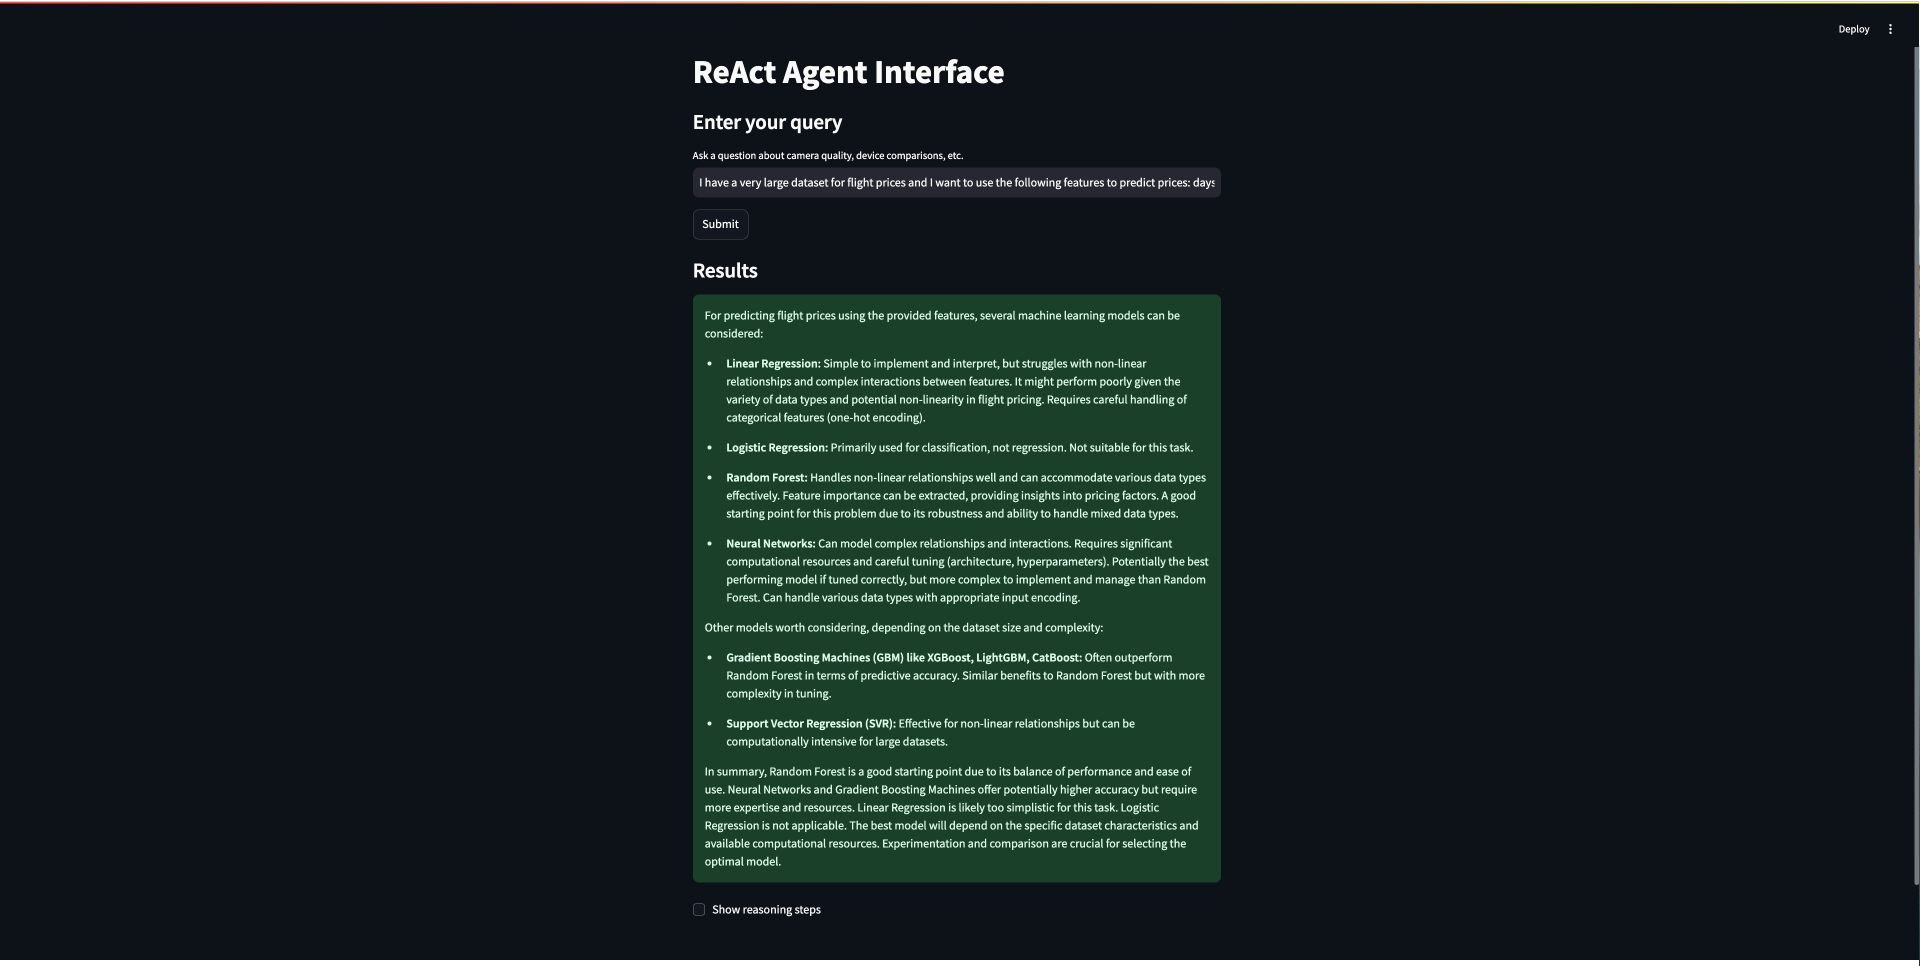